In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

BASE = os.path.expanduser("~/Desktop/bonds_project")
DATA = os.path.join(BASE, "data", "market_panel.csv")
FIGS = os.path.join(BASE, "figs")
os.makedirs(FIGS, exist_ok=True)

panel = pd.read_csv(DATA, index_col=0, parse_dates=True)

# Keep rows where both yields and ETFs exist
cols = ['y_2','y_5','y_10','y_30','IEF','TLT']
data = panel[cols].dropna().copy()

# Backtest window (edit if you want shorter/longer)
start_date = pd.Timestamp("2018-01-02")
end_date   = data.index.max()
data = data.loc[(data.index >= start_date) & (data.index <= end_date)].copy()
print("Backtest window:", data.index.min().date(), "→", data.index.max().date(), "n =", len(data))

Backtest window: 2018-01-02 → 2025-10-20 n = 2035



Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def build_curve_from_row(row):
    return {2.0: row['y_2']/100.0, 5.0: row['y_5']/100.0, 10.0: row['y_10']/100.0, 30.0: row['y_30']/100.0}

def interp_zero_rate(curve, t_years):
    ks = np.array(sorted(curve.keys()))
    rs = np.array([curve[k] for k in ks])
    t  = float(np.clip(t_years, ks.min(), ks.max()))
    return float(np.interp(t, ks, rs))

def discount_factor_from_curve(curve, t, comp='cont'):
    r = interp_zero_rate(curve, t)
    if comp == 'cont':   return np.exp(-r*t)
    if comp == 'simple': return 1.0/(1.0 + r*t)
    raise ValueError

def bond_cashflows(T, c, freq=2, face=100.0):
    n = int(round(T*freq))
    times = np.arange(1, n+1, dtype=float)/float(freq)
    times[-1] = T
    cpn = c*face/float(freq)
    cfs = np.full_like(times, cpn, dtype=float); cfs[-1] += face
    return list(zip(times, cfs))

def price_from_curve(curve, T, c, freq=2, face=100.0, comp='cont'):
    pv = 0.0
    for t, cf in bond_cashflows(T, c, freq=freq, face=face):
        pv += cf*discount_factor_from_curve(curve, t, comp=comp)
    return float(pv)

def portfolio_price(curve, bonds, comp='cont'):
    return float(sum(b["q"]*price_from_curve(curve, b["T"], b["c"], freq=b["f"], face=b["F"], comp=comp) for b in bonds))

def portfolio_krdv01s(curve, bonds, comp='cont', bump_bp=1.0, keys=(2.0,5.0,10.0,30.0)):
    P0 = portfolio_price(curve, bonds, comp=comp)
    out = {}
    for k in keys:
        bumped = dict(curve)
        if k not in bumped: bumped[k] = interp_zero_rate(curve, k)
        bumped[k] += bump_bp/10000.0
        P_up = portfolio_price(bumped, bonds, comp=comp)
        out[k] = float((P_up - P0)/(-bump_bp))  # per 1bp, $ per $100
    return out

def portfolio_parallel_dv01(curve, bonds, comp='cont', bump_bp=1.0):
    P0 = portfolio_price(curve, bonds, comp=comp)
    bump = bump_bp/10000.0
    up   = {k:v+bump for k,v in curve.items()}
    down = {k:v-bump for k,v in curve.items()}
    Pu = portfolio_price(up, bonds, comp=comp); Pd = portfolio_price(down, bonds, comp=comp)
    dur  = - (Pu - Pd)/(2.0*bump*P0)
    dv01 = - dur*P0*1e-4
    return float(dv01)


In [3]:
# === Your portfolio (per $100 notional) ===
def bond_spec(T, c, freq=2, face=100.0, qty=1.0):
    return {"T":float(T), "c":float(c), "f":int(freq), "F":float(face), "q":float(qty)}

BONDS = [
    bond_spec(2.0, 0.03, 2, 100.0, 1.0),
    bond_spec(5.0, 0.03, 2, 100.0, 1.0),
    bond_spec(10.0,0.03, 2, 100.0, 1.0),
]

# Build Δy (bp) and ETF returns for regressions
df = panel[['y_2','y_5','y_10','y_30','IEF','TLT']].dropna().copy()
for col in ['y_2','y_5','y_10','y_30']:
    df['d_'+col] = df[col].diff()*100.0  # bp
df['ret_IEF'] = df['IEF'].pct_change()
df['ret_TLT'] = df['TLT'].pct_change()
df = df.dropna()


In [4]:
def etf_krd_from_reg(reg_df, ticker, current_price):
    """
    OLS: r_t = b2*dy2_t + b5*dy5_t + b10*dy10_t + b30*dy30_t + c.
    KRD_k ≈ -beta_k * price  (per bp, $ per $100 notionally).
    Returns (KRD dict, DV01, R2).
    """
    ycols = ['d_y_2','d_y_5','d_y_10','d_y_30']
    X = reg_df[ycols].values
    y = reg_df['ret_'+ticker].values
    X_ = np.column_stack([X, np.ones(len(X))])
    beta, *_ = np.linalg.lstsq(X_, y, rcond=None)
    resid = y - X_.dot(beta)
    ss_res = float(np.sum(resid**2)); ss_tot = float(np.sum((y - y.mean())**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot>0 else np.nan
    betas = dict(zip([2.0,5.0,10.0,30.0], beta[:4]))
    KRD = {k: float(-betas[k]*current_price) for k in betas.keys()}
    DV01 = float(sum(KRD.values()))
    return KRD, DV01, r2


In [5]:
# Config
keys = [2.0,5.0,10.0,30.0]
lookback_days = 504  # ~2y of trading days for regression window
min_obs = 252       # need at least 1y of data to estimate KRDs
rebalance_freq = 'M'  # 'M' monthly; use 'W-FRI' for weekly

timeline = data.index
rebal_dates = pd.date_range(timeline.min(), timeline.max(), freq=rebalance_freq)
rebal_dates = [d for d in rebal_dates if d in timeline]
if timeline[-1] not in rebal_dates:
    rebal_dates.append(timeline[-1])

# State
current_h = np.array([0.0, 0.0])  # LONG units (IEF, TLT); we will SHORT these to hedge
instruments = ['IEF','TLT']

records = []
prev_prices = None  # (portfolio_price, IEF_price, TLT_price)

for t in timeline:
    row = data.loc[t]
    curve_t = build_curve_from_row(row)
    # Portfolio price at t
    P_port_t = portfolio_price(curve_t, BONDS)

    # ETF prices at t
    P_IEF_t = float(row['IEF'])
    P_TLT_t = float(row['TLT'])

    # Rebalance on schedule
    if t in rebal_dates:
        # trailing window for regression ends at t-1 (no look-ahead)
        past_end = t - pd.Timedelta(days=1)
        past_start = past_end - pd.tseries.offsets.BDay(lookback_days)
        reg_win = df.loc[(df.index >= past_start) & (df.index <= past_end)].copy()

        # Only rebalance if we have enough history
        if len(reg_win) >= min_obs:
            KRD_port = portfolio_krdv01s(curve_t, BONDS, keys=keys)
            b_vec = np.array([KRD_port.get(k,0.0) for k in keys], dtype=float)

            # Instrument KRDs from trailing regression
            KRD_I, DV01_I, R2_I = etf_krd_from_reg(reg_win, 'IEF', P_IEF_t)
            KRD_T, DV01_T, R2_T = etf_krd_from_reg(reg_win, 'TLT', P_TLT_t)

            A = np.column_stack([
                np.array([KRD_I.get(k,0.0) for k in keys], dtype=float),
                np.array([KRD_T.get(k,0.0) for k in keys], dtype=float),
            ])
            # Solve A h ≈ b (LONG units). To hedge, we will SHORT h.
            h, *_ = np.linalg.lstsq(A, b_vec, rcond=None)
            current_h = h
            # Optional: print brief status
            # print(t.date(), "rebalanced. R2(IEF,TLT)=", round(R2_I,2), round(R2_T,2), "h=", current_h)

    # Compute daily P&L (after possible rebalance) using yesterday's prices
    if prev_prices is None:
        dPnL_port = 0.0
        dPnL_hedge = 0.0
    else:
        dP_port  = P_port_t - prev_prices['P_port']
        dP_IEF   = P_IEF_t - prev_prices['P_IEF']
        dP_TLT   = P_TLT_t - prev_prices['P_TLT']
        # Hedge is SHORT current_h, so hedge P&L = -h ⋅ ΔPrice
        dPnL_port  = dP_port
        dPnL_hedge = - (current_h[0]*dP_IEF + current_h[1]*dP_TLT)

    records.append({
        "date": t, "P_port": P_port_t, "IEF": P_IEF_t, "TLT": P_TLT_t,
        "h_IEF": current_h[0], "h_TLT": current_h[1],
        "dPnL_port": dPnL_port, "dPnL_hedge": dPnL_hedge,
        "dPnL_combo": dPnL_port + dPnL_hedge
    })

    prev_prices = {"P_port": P_port_t, "P_IEF": P_IEF_t, "P_TLT": P_TLT_t}

bt = pd.DataFrame.from_records(records).set_index("date")
bt.to_csv(os.path.join(BASE, "data", "backtest.csv"))
print("Saved backtest to:", os.path.join(BASE, "data", "backtest.csv"))
bt.tail()


Saved backtest to: /Users/oltimyrtaj/Desktop/bonds_project/data/backtest.csv


,P_port,IEF,TLT,h_IEF,h_TLT,dPnL_port,dPnL_hedge,dPnL_combo
date,,,,,,,,
2025-10-14,287.777137,97.21,90.86,2.176624,-0.199750,0.480071,-0.486229,-0.006157
2025-10-15,287.440768,97.10,90.66,2.176624,-0.199750,-0.336369,0.199479,-0.136891
2025-10-16,288.471060,97.55,91.34,2.176624,-0.199750,1.030292,-0.843651,0.186641
2025-10-17,287.943888,97.39,91.20,2.176624,-0.199750,-0.527172,0.320295,-0.206877
2025-10-20,287.943888,97.52,91.54,2.190629,-0.202766,0.000000,-0.215841,-0.215841


In [6]:
def ann_vol(x):
    return np.std(x.dropna())*np.sqrt(252)

def max_drawdown(series):
    cum = series.cumsum()
    peak = cum.cummax()
    dd = cum - peak
    return float(dd.min())

def hist_var(x, p=0.95):
    # one-day historical VaR at confidence p (reported as negative loss threshold)
    q = np.quantile(x.dropna(), 1-p)
    return float(q)

summary = pd.Series({
    "AnnVol_port": ann_vol(bt["dPnL_port"]),
    "AnnVol_combo": ann_vol(bt["dPnL_combo"]),
    "VarianceReduction_%": 100*(1 - (np.var(bt["dPnL_combo"].dropna()) / np.var(bt["dPnL_port"].dropna()))),
    "TE_vol": ann_vol(bt["dPnL_combo"] - bt["dPnL_port"]),
    "MaxDD_port": max_drawdown(bt["dPnL_port"]),
    "MaxDD_combo": max_drawdown(bt["dPnL_combo"]),
    "VaR95_port": hist_var(bt["dPnL_port"], 0.95),
    "VaR95_combo": hist_var(bt["dPnL_combo"], 0.95),
    "VaR99_port": hist_var(bt["dPnL_port"], 0.99),
    "VaR99_combo": hist_var(bt["dPnL_combo"], 0.99),
})
print(summary.round(4))


AnnVol_port            13.3055
AnnVol_combo            5.5414
VarianceReduction_%    82.6548
TE_vol                  9.9835
MaxDD_port            -73.0640
MaxDD_combo           -30.4559
VaR95_port             -1.3505
VaR95_combo            -0.5417
VaR99_port             -2.2298
VaR99_combo            -0.9118
dtype: float64


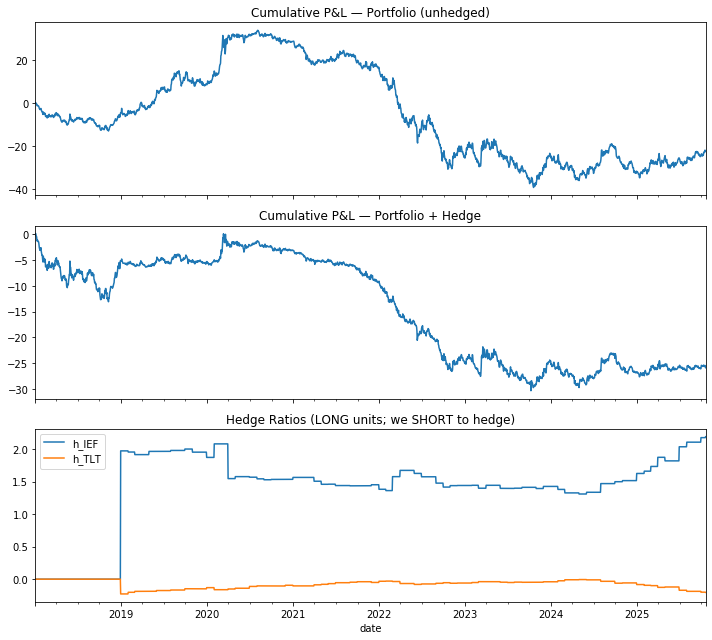

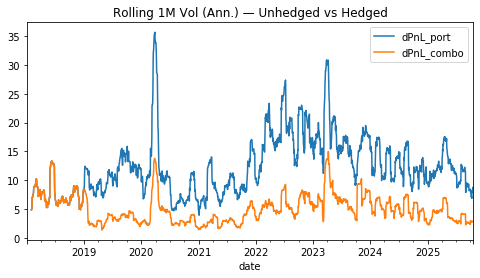

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if sys.path[0] == '':


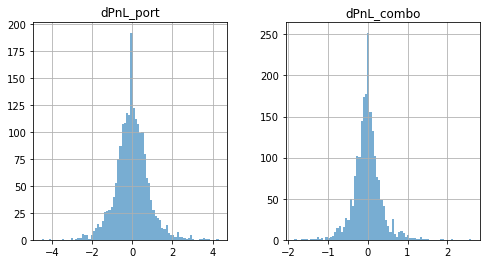

In [7]:
fig, axes = plt.subplots(3,1, figsize=(10,9), sharex=True)
(bt["dPnL_port"].cumsum()).plot(ax=axes[0], title="Cumulative P&L — Portfolio (unhedged)")
(bt["dPnL_combo"].cumsum()).plot(ax=axes[1], title="Cumulative P&L — Portfolio + Hedge")
(bt[["h_IEF","h_TLT"]]).plot(ax=axes[2], title="Hedge Ratios (LONG units; we SHORT to hedge)")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1,1, figsize=(8,4))
bt[["dPnL_port","dPnL_combo"]].dropna().rolling(21).std().multiply(np.sqrt(252)).plot(ax=ax)
ax.set_title("Rolling 1M Vol (Ann.) — Unhedged vs Hedged"); plt.show()

fig, ax = plt.subplots(1,1, figsize=(8,4))
bt[["dPnL_port","dPnL_combo"]].hist(bins=80, ax=ax, alpha=0.6)
ax.set_title("One-day P&L Distribution"); plt.show()

# Save figures
figpath = os.path.join(FIGS, "backtest_plots.png")
plt.figure(figsize=(10,1)); plt.text(0.01,0.5,"(plots above not auto-saved)\nExport as needed", va='center'); plt.axis('off')
plt.savefig(figpath, dpi=120, bbox_inches='tight'); plt.close()
